## INTRODUCTION
- It’s a Python based scientific computing package targeted at two sets of audiences:
    - A replacement for NumPy to use the power of GPUs
    - Deep learning research platform that provides maximum flexibility and speed
- pros: 
    - Iinteractively debugging PyTorch. Many users who have used both frameworks would argue that makes pytorch significantly easier to debug and visualize.
    - Clean support for dynamic graphs
    - Organizational backing from Facebook
    - Blend of high level and low level APIs
- cons:
    - Much less mature than alternatives
    - Limited references / resources outside of the official documentation
- I accept you know neural network basics. If you do not know check my tutorial. Because I will not explain neural network concepts detailed, I only explain how to use pytorch for neural network
- Neural Network tutorial: https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners 
- The most important parts of this tutorial from matrices to ANN. If you learn these parts very well, implementing remaining parts like CNN or RNN will be very easy. 
<br>
<br>**Content:**
1. Basics of Pytorch, Linear Regression, Logistic Regression, Artificial Neural Network (ANN), Concolutional Neural Network (CNN)
    - https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers/code
1. [Recurrent Neural Network (RNN)](#1)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


<a id="1"></a> <br>
### Recurrent Neural Network (RNN)
- RNN is essentially repeating ANN but information get pass through from previous non-linear activation function output.
- **Steps of RNN:**
    1. Import Libraries
    1. Prepare Dataset
    1. Create RNN Model
        - hidden layer dimension is 100
        - number of hidden layer is 1 
    1. Instantiate Model Class
    1. Instantiate Loss Class
        - Cross entropy loss
        - It also has softmax(logistic function) in it.
    1. Instantiate Optimizer Class
        - SGD Optimizer
    1. Traning the Model
    1. Prediction

In [2]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

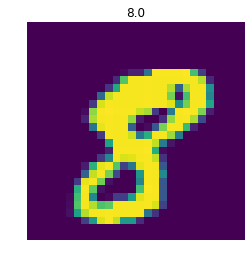

In [3]:
# Prepare Dataset
# load data
train = pd.read_csv(r"../input/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [4]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, 
                          nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: 1.6116942167282104  Accuracy: 39 %
Iteration: 1000  Loss: 0.4752371311187744  Accuracy: 68 %
Iteration: 1500  Loss: 0.5150447487831116  Accuracy: 84 %
Iteration: 2000  Loss: 0.29228368401527405  Accuracy: 92 %


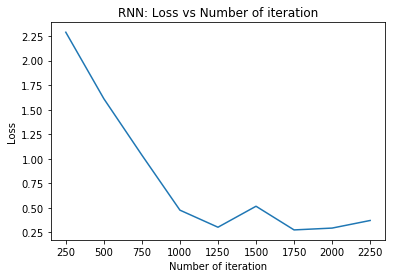

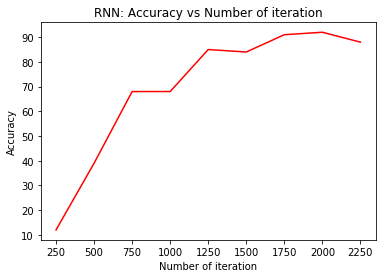

In [6]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()

### Conclusion
In this tutorial, we learn: 
1. Basics of pytorch
1. Linear regression with pytorch
1. Logistic regression with pytorch
1. Artificial neural network with with pytorch
1. Convolutional neural network with pytorch
    - https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers/code
1. Recurrent neural network with pytorch

<br> If you have any question or suggest, I will be happy to hear it 